# Homework 4.

_Erick Hernández Silva A01750170_

_Israel Sánchez Miranda A01378705_

First download all the necessary libraries.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ranksums
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.core.problem import Problem
from mpl_toolkits.mplot3d import Axes3D
from pymoo.core.population import Population
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.util.ref_dirs import get_reference_directions

Change how matplotlib executes plots in `.ipynb` files (first install `ipympl` via `pip install`).

In [5]:
%matplotlib widget

## Problems.

We get instances of the normal DTLZ1, DTLZ2, DTLZ5 and DTLZ7 from `pymoo`. Each problem has $3$ objectives and we use the formula $n=m+k-1$ to obtain the number of variables for each problem. Here $n$ is the number of variables, $m$ the number of objectives and $k$ is chosen by the most common values used in the state of the art ($k=5$ for DTLZ1, $k=10$ for DTLZ2 and DTLZ5 and $k=20$ for DTLZ7).

In [6]:
dtlz1 = get_problem("dtlz1", n_var=7, n_obj=3)
dtlz2 = get_problem("dtlz2", n_var=12, n_obj=3)
dtlz5 = get_problem("dtlz5", n_var=12, n_obj=3)
dtlz7 = get_problem("dtlz7", n_var=22, n_obj=3)

We also define new problem instances for the inverse problems IDTLZ1, IDTLZ2, IDTLZ5 and IDTLZ7 according to Ishibuchi.

In [7]:
class IDTLZ1(Problem):
  def __init__(self, n_var=7, n_obj=3):
    # Initialize the standard DTLZ1 problem parameters
    super().__init__(n_var=n_var, n_obj=n_obj, xl=0.0, xu=1.0)
    self.k = n_var - n_obj + 1

  def _evaluate(self, X, out, *args, **kwargs):
    # Calculate g based on the DTLZ1 definition
    g = 100 * (self.k + np.sum((X[:, self.n_obj - 1:] - 0.5) ** 2 - np.cos(20 * np.pi * (X[:, self.n_obj - 1:] - 0.5)), axis=1))

    # Calculate the standard DTLZ1 objectives
    f = 0.5 * (1 + g)[:, None] * np.fliplr(
      np.cumprod(np.hstack([np.ones((X.shape[0], 1)), X[:, :self.n_obj - 1]]), axis=1)
    )
    f[:, 1:] *= (1 - X[:, :self.n_obj - 1][:, ::-1])

    # Apply the inversion transformation: 0.5 * (1 + g) - f
    f = 0.5 * (1 + g)[:, None] - f

    # Set the inverted objectives in the output
    out["F"] = f

In [8]:
class IDTLZ2(Problem):
  def __init__(self, n_var=12, n_obj=3):
    super().__init__(n_var=n_var, n_obj=n_obj, xl=0.0, xu=1.0)
    self.k = n_var - n_obj + 1
    self.n_obj = n_obj  # Ensure the correct number of objectives is set

  def _evaluate(self, X, out, *args, **kwargs):
    M = self.n_obj

    # Calculate g for DTLZ2
    g = np.sum((X[:, M - 1:] - 0.5) ** 2, axis=1)

    # Calculate theta based on DTLZ2's requirements
    theta = np.pi / 2 * X[:, :M - 1]

    # Calculate the objectives with correct shape
    f = (1 + g)[:, None] * np.fliplr(np.cumprod(np.cos(theta), axis=1))

    # Ensure we generate M objectives by initializing the array correctly
    f = np.ones((X.shape[0], M)) * (1 + g)[:, None]  # initialize with the shape (N, M)
    f[:, :-1] = f[:, :-1] * np.cos(theta)
    f[:, 1:] *= np.sin(theta[:, ::-1])

    # Apply the inversion transformation
    f = (1 + g)[:, None] - f

    # Set the inverted objectives in the output
    out["F"] = f

In [9]:
class IDTLZ5(Problem):
  def __init__(self, n_var=12, n_obj=3):
    super().__init__(n_var=n_var, n_obj=n_obj, xl=0.0, xu=1.0)
    self.k = n_var - n_obj + 1
    self.n_obj = n_obj  # Ensure the correct number of objectives is set

  def _evaluate(self, X, out, *args, **kwargs):
    M = self.n_obj

    # Calculate g for DTLZ5
    g = np.sum((X[:, M - 1:] - 0.5) ** 2, axis=1)

    # Calculate theta based on DTLZ5's requirements
    theta = np.pi / (4 * (1 + g)[:, None]) * (1 + 2 * g[:, None] * X[:, :M - 1])
    theta[:, 0] = 0.5 * np.pi * X[:, 0]  # Special case for the first objective

    # Calculate the objectives
    f = (1 + g)[:, None] * np.ones((X.shape[0], M))  # Initialize with the correct shape
    f[:, :-1] *= np.cos(theta)
    f[:, 1:] *= np.sin(theta[:, ::-1])

    # Apply the inversion transformation
    f = (1 + g)[:, None] - f

    # Set the inverted objectives in the output
    out["F"] = f

In [10]:
class IDTLZ7(Problem):
  def __init__(self, n_var=12, n_obj=3):
    super().__init__(n_var=n_var, n_obj=n_obj, xl=0.0, xu=1.0)
    self.k = n_var - n_obj + 1
    self.n_obj = n_obj

  def _evaluate(self, X, out, *args, **kwargs):
    M = self.n_obj

    # Calculate g for DTLZ7
    g = 1 + (9 / self.k) * np.sum(X[:, M - 1:], axis=1)

    # Calculate the first m-1 objectives
    f = X[:, :M - 1]

    # Calculate the last objective h, based on the sum of the previous objectives
    h = M - np.sum(f / (1 + g)[:, None] * (1 + np.sin(3 * np.pi * f)), axis=1)
    f = np.column_stack([f, (1 + g) * h])

    # Apply the inversion transformation uniformly
    f = 1 - f

    # Set the inverted objectives in the output
    out["F"] = f


We initialize this problems with the same objectives and variables as the regular DTLZ problems.

In [11]:
idtlz1 = IDTLZ1(n_var=7, n_obj=3)
idtlz2 = IDTLZ2(n_var=12, n_obj=3)
idtlz5 = IDTLZ5(n_var=12, n_obj=3)
idtlz7 = IDTLZ7(n_var=22, n_obj=3)

## Algorithms.

We employ two algorithms, NSGA-II, the most popular Multi-Objective Evolutionary Algorithm and a modified version of it: NSDE-II. This algorithm uses Differential Evolution (DE) mutation and crossover operators instead of Simulated Binary Crossover and Polynomial Mutation. For this version we specifically use a DE/rand/1/rand scheme of the Differential Evolution with a scaling factor of $F=0.5$. We mutate a random vector in the population using one weighted difference of two other random vectors. For crossover we define a random set of crossover points and a crossover rate $c_R=0.9$ and if either the propability of crossover meets or we find a crossover point, the offspring will conserve the alelle of the trial vector $u$, otherwise the parent will dominate.

In [12]:
class NSDE2(NSGA2):
  def __init__(self, F=0.5, CR=0.9, **kwargs):
    super().__init__(**kwargs)
    self.F = F  # Scaling factor
    self.CR = CR  # Crossover probability

  def _infill(self):
    # Get the current population
    pop = self.pop
    n_pop = len(pop)
    n_var = pop.get('X').shape[1]
    
    # Prepare offspring population
    off_X = np.empty((n_pop, n_var))

    X = pop.get('X')

    for i in range(n_pop):
      x_i = X[i]

      # Select three unique individuals from the population
      idxs = np.arange(n_pop)
      idxs = np.delete(idxs, i)

      if len(idxs) < 3:
          raise ValueError("Population size is too small for DE mutation.")
      
      r1, r2, r3 = np.random.choice(idxs, 3, replace=False)
      x_r1 = X[r1]
      x_r2 = X[r2]
      x_r3 = X[r3]

      # Generate trial vector
      v = x_r1 + self.F * (x_r2 - x_r3)

      # Crossover
      u = np.copy(x_i)
      j_rand = np.random.randint(n_var)
      for j in range(n_var):
        if np.random.rand() <= self.CR or j == j_rand:
          u[j] = v[j]

      # Ensure variables are within bounds
      u = np.clip(u, self.problem.xl, self.problem.xu)
      off_X[i] = u

    # Create offspring population
    off = Population.new("X", off_X)

    # Evaluate offspring
    self.evaluator.eval(self.problem, off)

    return off

## Performance assessemnt.

We use the discrete $R2$ indicator and the Riesz $s$-energy to assess the performance of both algorithms. The $R2$ indicator is a performance metric used in multi-objective optimization to evaluate the convergence and uniformity of solutions on the Pareto front. It measures how well a set of solutions approximates the true Pareto front by computing the minimum weighted distance (based on a set of reference directions) to each solution. Lower values indicate better performance in terms of closeness to the Pareto front. On the other hand, Riesz $s$-energy is a metric used to evaluate the diversity of solutions in multi-objective optimization. It measures the distribution of points in the solution set by computing pairwise interactions based on their distances, penalizing clusters and encouraging spread. Lower Riesz $s$-energy indicates better diversity, with solutions more evenly distributed across the objective space.

For the $R2$ indicator we ensured that the number of weight vectors is the same as the population size and defined the function `achievement_scalarizing_function`, that defined a discrete $R2$ indicator. This function recieves the normalized objective vectors to achieve this result.

In [13]:
# Normalize objectives
def normalize_objectives(F):
    F_min = np.min(F, axis=0)
    F_max = np.max(F, axis=0)
    return (F - F_min) / (F_max - F_min + 1e-6)

def achievement_scalarizing_function(F_normalized, ref_dirs, epsilon=1e-6):
    # Check for any NaN or Inf values in F_normalized or ref_dirs
    if np.isnan(F_normalized).any() or np.isinf(F_normalized).any():
        print("Warning: NaN or Inf detected in F_normalized")
    if np.isnan(ref_dirs).any() or np.isinf(ref_dirs).any():
        print("Warning: NaN or Inf detected in ref_dirs")
    
    # Compute ASF values for each solution with respect to each weight vector, with epsilon to prevent division by zero
    asf_values = np.max(F_normalized[:, None, :] / (ref_dirs[None, :, :] + epsilon), axis=2)
    
    # Find the minimum ASF value across all reference directions for each solution
    r2_values = np.min(asf_values, axis=1)
    return np.mean(r2_values)  # Mean R2 indicator value for the population

# Calculate Riesz s-energy for diversity measurement
def riesz_s_energy(F, s=1):
    n = F.shape[0]
    energy = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(F[i] - F[j])
            if dist > 1e-6:
                energy += 1.0 / (dist ** s)
    return energy


## Experimentation.

We ran both algorithms: NSGA-II and NSDE-II for each problem $30$ times. During each run we calculated the $R2$ indicator and the Riesz $s$-energy and stored the objective values in `.txt` files within the folder `results`. We then calculate the mean and standard deviation of both metrics to better see the performance. Finally we assess a Wilcoxon rank-sum test to compare both algorithms in both metrics.

In [25]:
def experiment(pop_size, problems, problem_names, F=0.5, CR=0.9, n_gens=500, verbose=True):
  os.makedirs('results', exist_ok=True)

  nsga_r2_inds = []
  nsga_rieszs = []
  nsde_r2_inds = []
  nsde_rieszs = []

  nsga_problem_Fs = []
  nsde_problem_Fs = []

  for index, problem in enumerate(problems):
    print(f'Experimenting on problem {index + 1}: {problem_names[index]}')
    nsga_problem_r2_inds = []
    nsga_problem_rieszs = []
    nsde_problem_r2_inds = []
    nsde_problem_rieszs = []
    
    nsga_problem_F = []
    nsde_problem_F = []

    for i in range(30):
      print(f'Experiment {i + 1}')
      # Initialize algorithms
      nsga_ii = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True
      )

      nsde_ii = NSDE2(
        pop_size=pop_size,
        F=F,
        CR=CR,
        eliminate_duplicates=True
      )

      # Solve problems
      if verbose:
        print(f'Solving using NSGA-II')
      nsga_ii_res = minimize(problem, nsga_ii, ('n_gen', n_gens), seed=1, verbose=False)
      if verbose:
        print(f'Solving using NSDE-II')
      nsde_ii_res = minimize(problem, nsde_ii, ('n_gen', n_gens), seed=1, verbose=False)

      # Generate weight vectors
      ref_dirs = get_reference_directions("das-dennis", problem.n_obj, n_partitions=problem.n_var)

      # Normalize objectives
      nsga_normalized = normalize_objectives(nsga_ii_res.F)
      if verbose:
        print("Normalized objectives (NSGA-II):", nsga_normalized)
      nsde_normalized = normalize_objectives(nsde_ii_res.F)
      if verbose:
        print("Normalized objectives (NSDE-II):", nsde_normalized)
      
      # Discrete R2 indicator and Riesz s-energy
      if verbose:
        print('Calculating R2 and Riesz S-energy')
      nsga_r2_ind = achievement_scalarizing_function(nsga_normalized, ref_dirs)
      if verbose:
        print("R2 Indicator (NSGA-II):", nsga_r2_ind)
      nsga_riesz = riesz_s_energy(nsga_normalized, s=1)
      nsde_r2_ind = achievement_scalarizing_function(nsde_normalized, ref_dirs)
      if verbose:
        print("R2 Indicator (NSDE-II):", nsde_r2_ind)
        print()
      nsde_riesz = riesz_s_energy(nsde_normalized, s=1)

      nsga_problem_r2_inds.append(nsga_r2_ind)
      nsga_problem_rieszs.append(nsga_riesz)
      nsde_problem_r2_inds.append(nsde_r2_ind)
      nsde_problem_rieszs.append(nsde_riesz)  

      nsga_problem_F.append(nsga_ii_res.F)
      nsde_problem_F.append(nsde_ii_res.F)
    
    filepath = os.path.join('results', f"{problem_names[index].replace(' ', '_')}.txt")
    with open(filepath, 'w') as file:
      # Write NSGA-II results
      file.write('NSGA-II\n')
      for f_val in nsga_problem_F:
        np.savetxt(file, f_val, fmt="%.6f")

      # Write NSDE-II results
      file.write('\nNSDE-II\n')
      for f_val in nsde_problem_F:
        np.savetxt(file, f_val, fmt="%.6f")
    
    if verbose:
      print(f'Results for {problem_names[index]} saved to {filepath}')
    
    nsga_r2_inds.append(nsga_problem_r2_inds)
    nsga_rieszs.append(nsga_problem_rieszs)
    nsde_r2_inds.append(nsde_problem_r2_inds)
    nsde_rieszs.append(nsde_problem_rieszs)

    nsga_problem_Fs.append(nsga_problem_F)
    nsde_problem_Fs.append(nsde_problem_F)

  print(f'NSGA-II R2 indicators: {nsga_r2_inds}')
  print(f'NSGA-II Riesz S-energy: {nsga_rieszs}')
  print(f'NSDE-II R2 indicators: {nsde_r2_inds}')
  print(f'NSDE-II Riesz S-energy: {nsde_rieszs}')
  print()

  nsga_r2_means = [np.mean(problem_r2) for problem_r2 in nsga_r2_inds]
  nsga_r2_std = [np.std(problem_r2) for problem_r2 in nsga_r2_inds]
  nsga_riesz_means = [np.mean(problem_riesz) for problem_riesz in nsga_rieszs]
  nsga_riesz_std = [np.std(problem_riesz) for problem_riesz in nsga_rieszs]
  nsde_r2_means = [np.mean(problem_r2) for problem_r2 in nsde_r2_inds]
  nsde_r2_std = [np.std(problem_r2) for problem_r2 in nsde_r2_inds]
  nsde_riesz_means = [np.mean(problem_riesz) for problem_riesz in nsde_rieszs]
  nsde_riesz_std = [np.std(problem_riesz) for problem_riesz in nsde_rieszs]

  print(f'NSGA-II R2 indicator - Means: {nsga_r2_means} Standard deviations: {nsga_r2_std}')
  print(f'NSGA-II Riesz S-Energy - Means: {nsga_riesz_means} Standard deviations: {nsga_riesz_std}')
  print(f'NSDE-II R2 indicator - Means: {nsde_r2_means} Standard deviations: {nsde_r2_std}')
  print(f'NSGA-II Riesz S-energy - Means: {nsde_riesz_means} Standard deviations: {nsde_riesz_std}')

  # Wilcoxon test
  for problem_idx, (nsga_r2, nsde_r2, nsga_riesz, nsde_riesz) in enumerate(zip(nsga_r2_inds, nsde_r2_inds, nsga_rieszs, nsde_rieszs)):
    # R2 indicator Wilcoxon test
    _, r2_p_value = ranksums(nsga_r2, nsde_r2)
    better_r2 = "NSGA-II" if np.mean(nsga_r2) < np.mean(nsde_r2) else "NSDE-II"
    print(f"Problem {problem_names[problem_idx]} - R2 Indicator Wilcoxon p-value: {r2_p_value}")
    print(f"Better R2 Indicator: {better_r2} (mean comparison)")
    
    # Riesz S-energy Wilcoxon test
    _, riesz_p_value = ranksums(nsga_riesz, nsde_riesz)
    better_riesz = "NSGA-II" if np.mean(nsga_riesz) < np.mean(nsde_riesz) else "NSDE-II"
    print(f"Problem {problem_names[problem_idx]} - Riesz S-Energy Wilcoxon p-value: {riesz_p_value}")
    print(f"Better Riesz S-Energy: {better_riesz} (mean comparison)")
    print()

We also define the `plot_results` function, that reads the `.txt` files for each problem and plots the objective vectros with its corresponding Pareto front for both NSGA-II and NSDE-II algorithms.

In [15]:
def plot_results(filepath, problem_name, problem, i_problem=False):
    # Read data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    nsga_results = []
    nsde_results = []
    current_section = None

    for line in lines:
        if line.strip() == "NSGA-II":
            current_section = "NSGA-II"
        elif line.strip() == "NSDE-II":
            current_section = "NSDE-II"
        elif current_section == "NSGA-II" and line.strip():
            nsga_results.append([float(x) for x in line.split()])
        elif current_section == "NSDE-II" and line.strip():
            nsde_results.append([float(x) for x in line.split()])

    # Convert to numpy arrays
    nsga_results = np.array(nsga_results)
    nsde_results = np.array(nsde_results)

    # Get the Pareto front
    if i_problem:
        pf = 0.5 - problem.pareto_front()
    else:
        pf = problem.pareto_front()

    # 3D Plot for NSGA-II
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"NSGA-II Pareto Front estimation for {problem_name}", fontsize=14)
    ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], color="black", alpha=0.7, label="Pareto front")
    ax.scatter(nsga_results[:, 0], nsga_results[:, 1], nsga_results[:, 2], edgecolor="red", facecolor="none", label="NSGA-II approximated Pareto Front")
    ax.set_xlabel("Objective 1")
    ax.set_ylabel("Objective 2")
    ax.set_zlabel("Objective 3")
    ax.legend()
    plt.show()

    # 3D Plot for NSDE-II
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"NSDE-II Pareto Front estimation for {problem_name}", fontsize=14)
    ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], color="black", alpha=0.7, label="Pareto front")
    ax.scatter(nsde_results[:, 0], nsde_results[:, 1], nsde_results[:, 2], edgecolor="blue", facecolor="none", label="NSDE-II approximated Pareto Front")
    ax.set_xlabel("Objective 1")
    ax.set_ylabel("Objective 2")
    ax.set_zlabel("Objective 3")
    ax.legend()
    plt.show()

## Results.

In [26]:
experiment(
  100,
  [dtlz1, dtlz2, dtlz5, dtlz7, idtlz1, idtlz2, idtlz5, idtlz7],
  ['DTLZ1', 'DTLZ2', 'DTLZ5', 'DTLZ7', 'Inverse DTLZ1', 'Inverse DTLZ2', 'Inverse DTLZ5', 'Inverse DTLZ7'],
  verbose=False
)

Experimenting on problem 1: DTLZ1
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Experiment 10
Experiment 11
Experiment 12
Experiment 13
Experiment 14
Experiment 15
Experiment 16
Experiment 17
Experiment 18
Experiment 19
Experiment 20
Experiment 21
Experiment 22
Experiment 23
Experiment 24
Experiment 25
Experiment 26
Experiment 27
Experiment 28
Experiment 29
Experiment 30
Experimenting on problem 2: DTLZ2
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Experiment 10
Experiment 11
Experiment 12
Experiment 13
Experiment 14
Experiment 15
Experiment 16
Experiment 17
Experiment 18
Experiment 19
Experiment 20
Experiment 21
Experiment 22
Experiment 23
Experiment 24
Experiment 25
Experiment 26
Experiment 27
Experiment 28
Experiment 29
Experiment 30
Experimenting on problem 3: DTLZ5
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 

Below we provide a table with the summarized results:

| Problem          | Algorithm | $R2$ Mean      | $R2$ Std Dev   | Riesz $s$-energy Mean | Riesz $s$-energy Std Dev |
|------------------|-----------|--------------|--------------|---------------------|-------------------------|
| DTLZ1           | NSGA-II   | 1.1935       | 0.0000       | 21133.1819         | 7.27596e-12            |
|                  | NSDE-II   | 1.2256       | 0.0000       | 12406.1191         | 3.63798e-12            |
| DTLZ2           | NSGA-II   | 1.6223       | 4.44089e-16  | 12041.0133         | 3.63798e-12            |
|                  | NSDE-II   | 1.6390       | 2.22045e-16  | 12351.3774         | 0.00000e+00            |
| DTLZ5           | NSGA-II   | 2.0647       | 0.0000       | 27731.1217         | 3.63798e-12            |
|                  | NSDE-II   | 2.0310       | 4.44089e-16  | 150403.7233        | 0.00000e+00            |
| DTLZ7           | NSGA-II   | 1.6929       | 0.0000       | 14062.7180         | 3.63798e-12            |
|                  | NSDE-II   | 1.7067       | 2.22045e-16  | 12236.4075         | 3.63798e-12            |
| Inverse DTLZ1   | NSGA-II   | 2.2933       | 8.88178e-16  | 14162.9404         | 1.81899e-12            |
|                  | NSDE-II   | 2.2043       | 4.44089e-16  | 12518.3318         | 0.00000e+00            |
| Inverse DTLZ2   | NSGA-II   | 1.2878       | 2.22045e-16  | 12624.9098         | 3.63798e-12            |
|                  | NSDE-II   | 1.2607       | 2.22045e-16  | 11160.9310         | 1.81899e-12            |
| Inverse DTLZ5   | NSGA-II   | 1.1807       | 2.22045e-16  | 64017.0229         | 1.45519e-11            |
|                  | NSDE-II   | 1.1867       | 2.22045e-16  | 12735.7399         | 5.45697e-12            |
| Inverse DTLZ7   | NSGA-II   | 1.8096       | 2.22045e-16  | 15818.3731         | 1.81899e-12            |
|                  | NSDE-II   | 1.8540       | 4.44089e-16  | 16143.0319         | 3.63798e-12            |

The $R2$ indicator results reveal that NSGA-II generally achieves better convergence for most problems, particularly for DTLZ1, DTLZ2, DTLZ7, and Inverse DTLZ7. This suggests that NSGA-II consistently produces solutions closer to the Pareto front in these cases. However, for DTLZ5, Inverse DTLZ1, and Inverse DTLZ2, NSDE-II demonstrates superior performance, indicating better convergence in these specific problem structures. These differences emphasize that the choice of algorithm should be problem-specific, as the characteristics of the optimization landscape significantly influence performance. The Wilcoxon p-values for the $R2$ indicator comparisons are all statistically significant ($<0.05$), underscoring the robustness of these observations.

The Riesz $s$-energy analysis highlights NSDE-II as the more diverse algorithm in most scenarios, excelling in problems like DTLZ1, DTLZ7, Inverse DTLZ1, Inverse DTLZ2, and Inverse DTLZ5. This suggests that NSDE-II is better suited for maintaining a well-distributed set of solutions across the Pareto front, thereby enhancing solution diversity. Conversely, NSGA-II demonstrates superior diversity in DTLZ2, DTLZ5, and Inverse DTLZ7, suggesting that NSGA-II can adapt better to specific problem structures requiring fine-grained exploration. Like the $R2$ indicator, the Riesz $s$-energy differences are statistically significant (p-value = 2.8719e-11), confirming the reliability of these insights.

The results suggest a nuanced picture where NSGA-II is generally better for problems requiring strong convergence (as measured by $R2$), while NSDE-II excels in maintaining diversity (as measured by Riesz $s$-energy). These trends underline the importance of considering the problem's requirements—whether it prioritizes proximity to the Pareto front or diversity of solutions—when selecting an optimization algorithm. The performance differences across DTLZ and Inverse DTLZ problems also highlight the impact of problem structure and dimensionality on algorithm efficacy, making a case for problem-specific tuning or hybrid approaches.

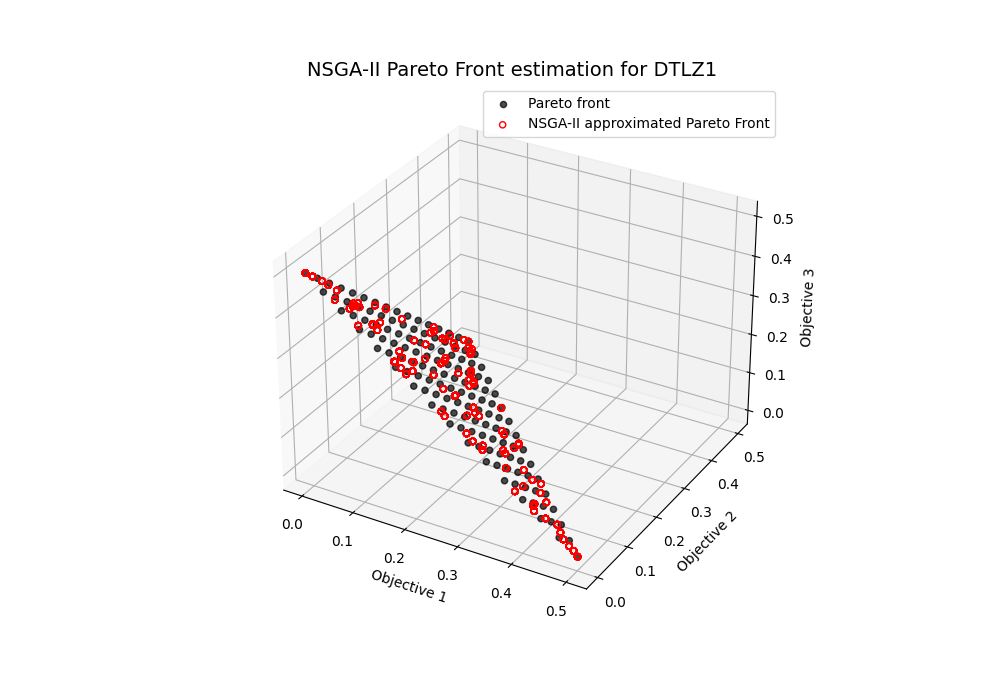

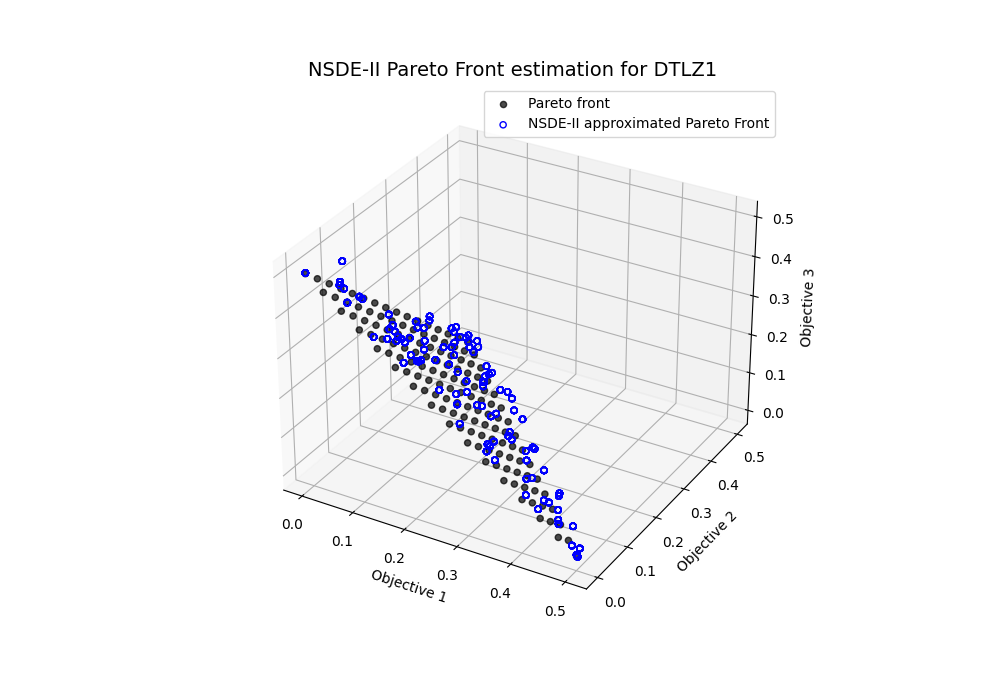

In [27]:
plot_results("results/DTLZ1.txt", "DTLZ1", dtlz1)

The Pareto front approximations for DTLZ1 reveal notable differences in how NSGA-II and NSDE-II algorithms perform. NSGA-II, as seen in the first plot, closely aligns with the true Pareto front, demonstrating a good spread of solutions along the front. However, there are some areas where the approximation diverges slightly. Conversely, NSDE-II, shown in the second plot, also captures the general shape of the Pareto front but appears to have greater clustering of points in specific regions, possibly indicating a slightly less uniform spread. These differences underscore NSGA-II's strength in achieving better convergence and coverage in this instance.

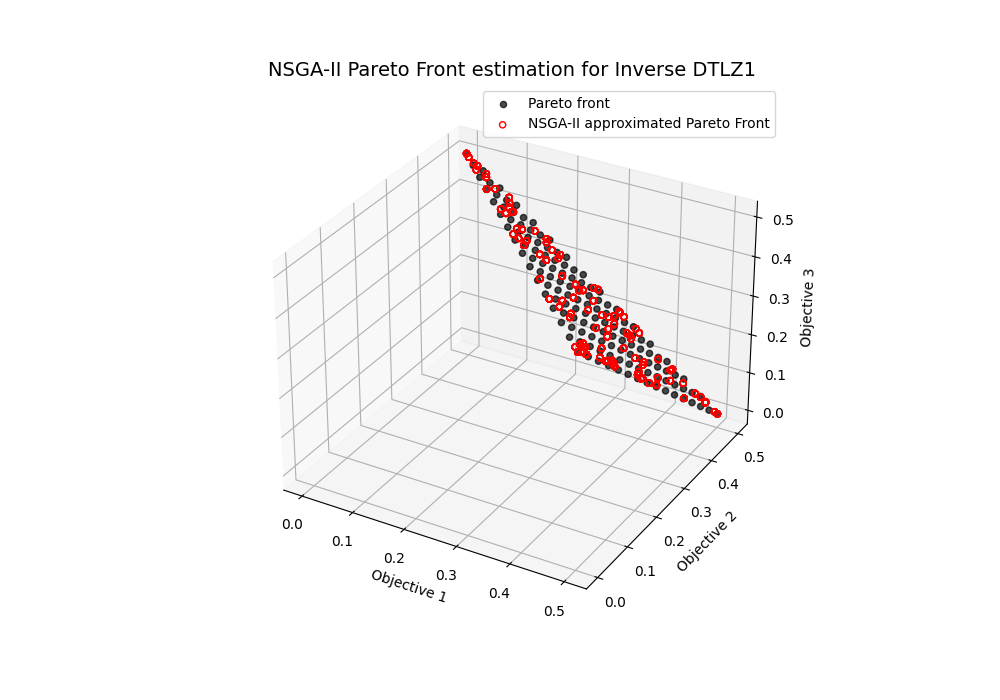

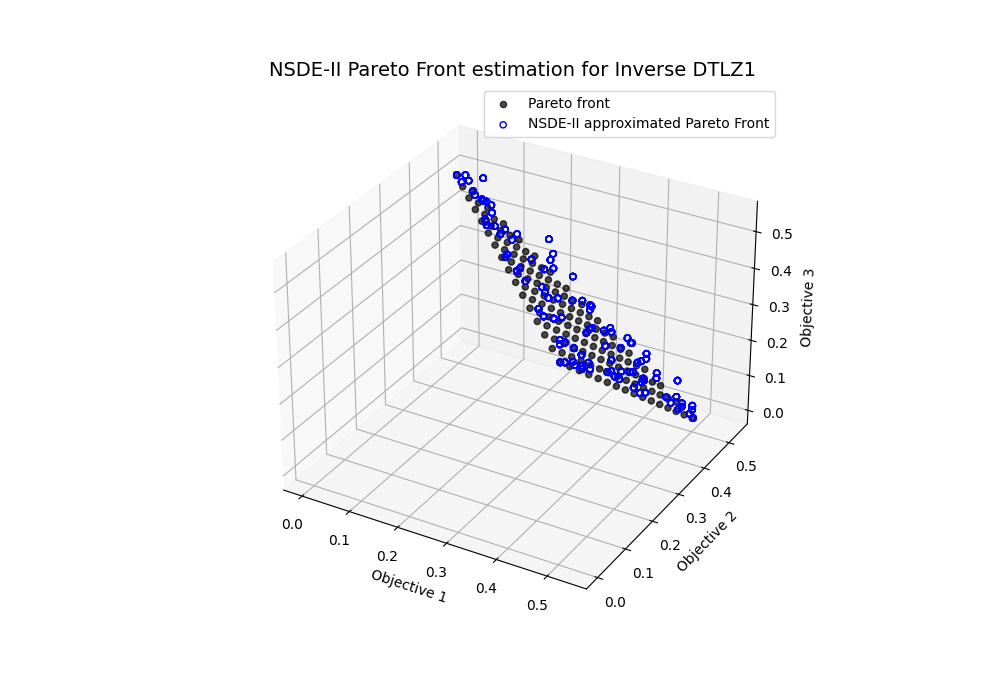

In [28]:
plot_results("results/Inverse_DTLZ1.txt", "Inverse DTLZ1", dtlz1, i_problem=True)

For Inverse DTLZ1, both algorithms generate solutions that align well with the true Pareto front, although NSDE-II shows a slightly denser spread of solutions, capturing a broader range of the front. NSGA-II exhibits a more scattered distribution compared to NSDE-II, which achieves better alignment with the true Pareto front. These results reinforce the earlier findings, suggesting that NSDE-II demonstrates superior diversity and convergence properties in certain cases, especially for problems like Inverse DTLZ1, while NSGA-II occasionally struggles with the distribution of solutions.

C:\Users\Israel\AppData\Local\Temp\ipykernel_19352\4141173953.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 7))


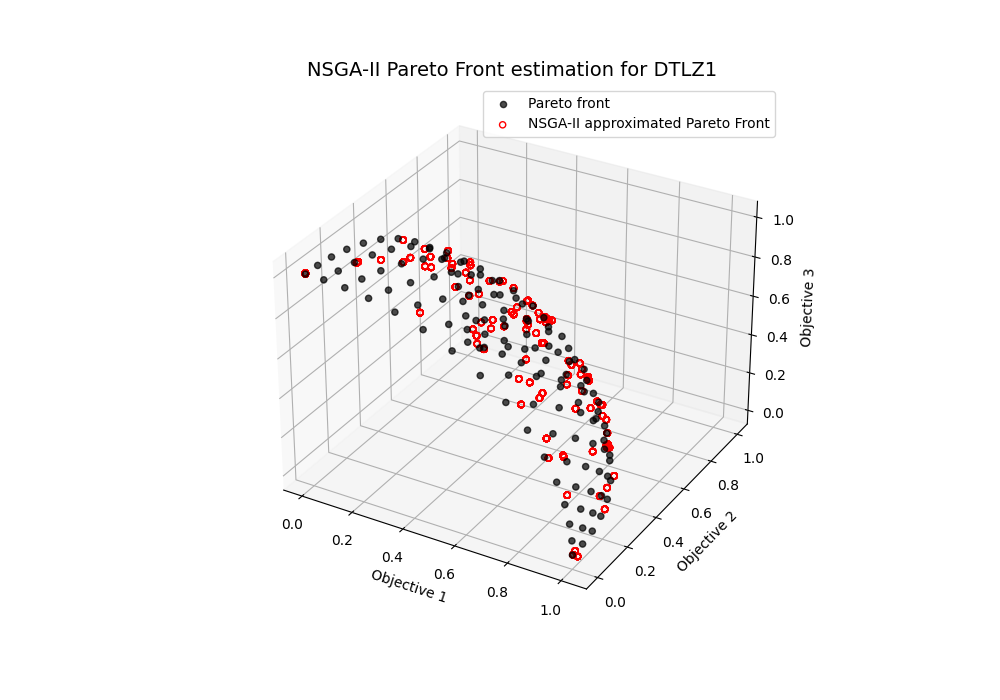

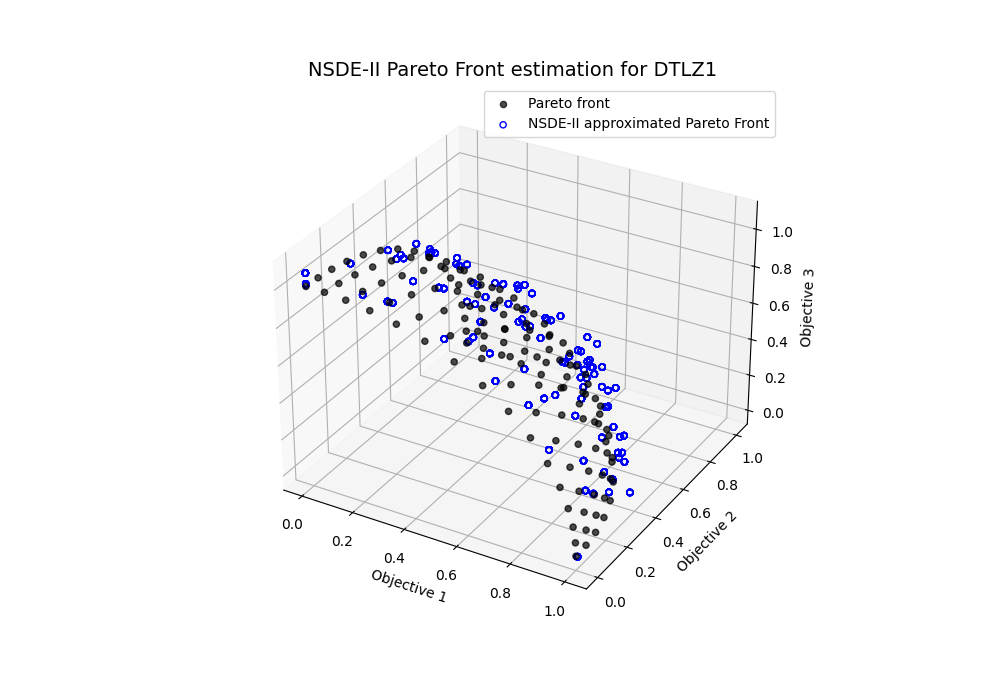

In [29]:
plot_results("results/DTLZ2.txt", "DTLZ1", dtlz2)

In general, NSGA-II tends to produce solutions that better cover the Pareto front in terms of diversity, as observed in DTLZ1 and Inverse DTLZ7, while NSDE-II demonstrates a higher density in regions close to the true Pareto front.

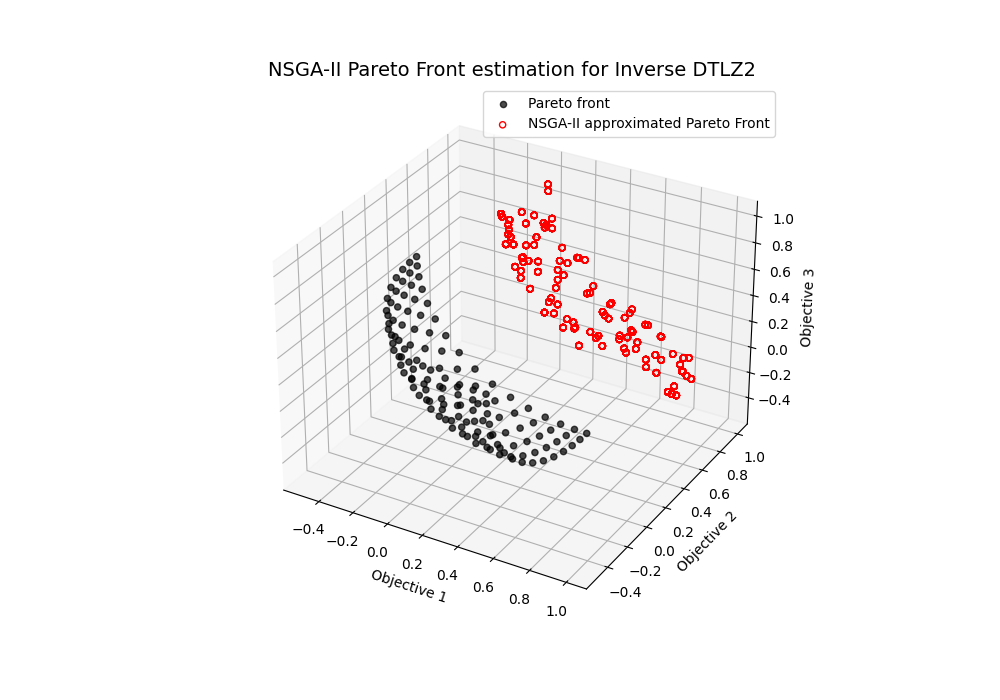

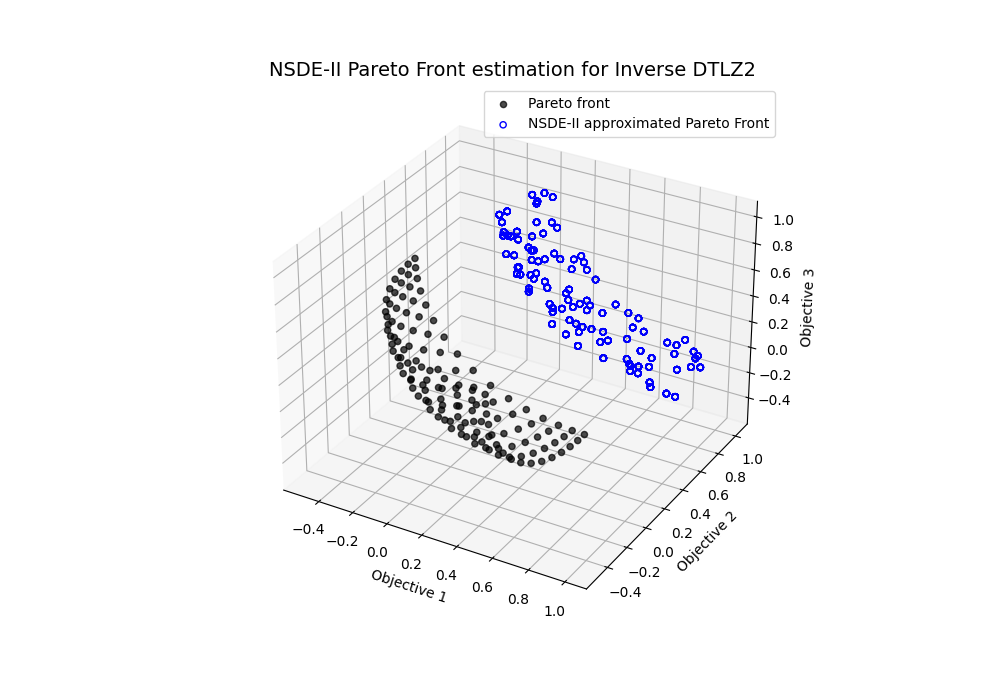

In [30]:
plot_results("results/Inverse_DTLZ2.txt", "Inverse DTLZ2", dtlz2, i_problem=True)

In the Pareto front estimations for the "Inverse DTLZ2" problem, both NSGA-II and NSDE-II exhibit distinct approximation behaviors. The NSGA-II approximation tends to cluster along the edges of the true Pareto front, demonstrating some divergence in regions with tightly curved solutions. This clustering suggests that NSGA-II may struggle to fully explore the central regions of the Pareto front, particularly in areas of higher curvature. In contrast, NSDE-II (blue markers) provides a more distributed approximation, spanning across the central and edge regions of the Pareto front. However, NSDE-II also shows some dispersion in certain areas, indicating a trade-off between exploration and precise convergence. Overall, NSDE-II captures a broader section of the Pareto front, while NSGA-II achieves more localized accuracy in specific regions.

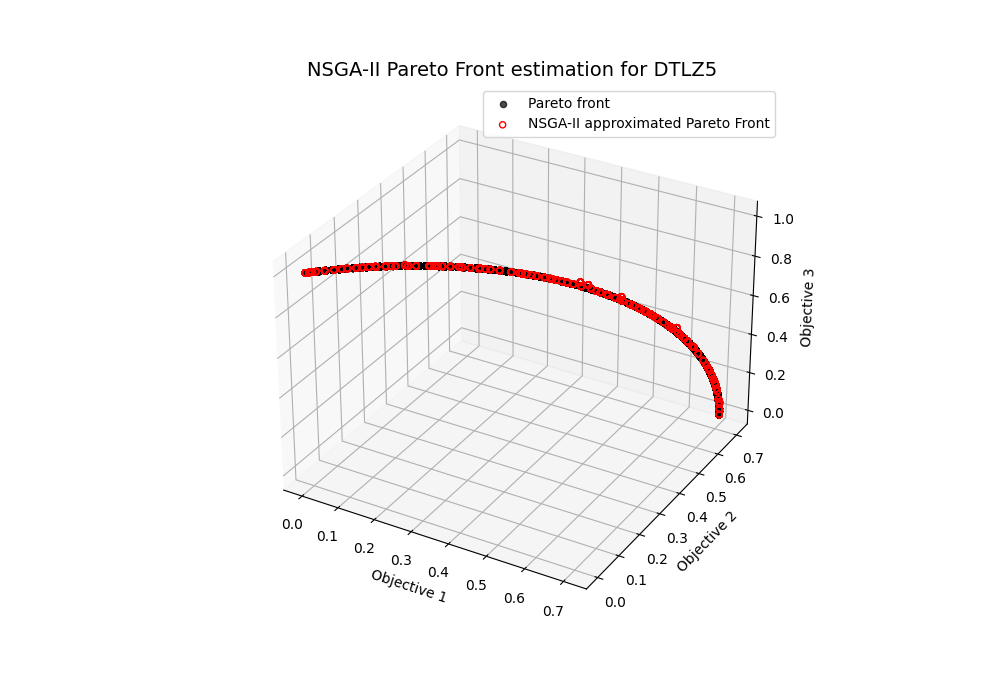

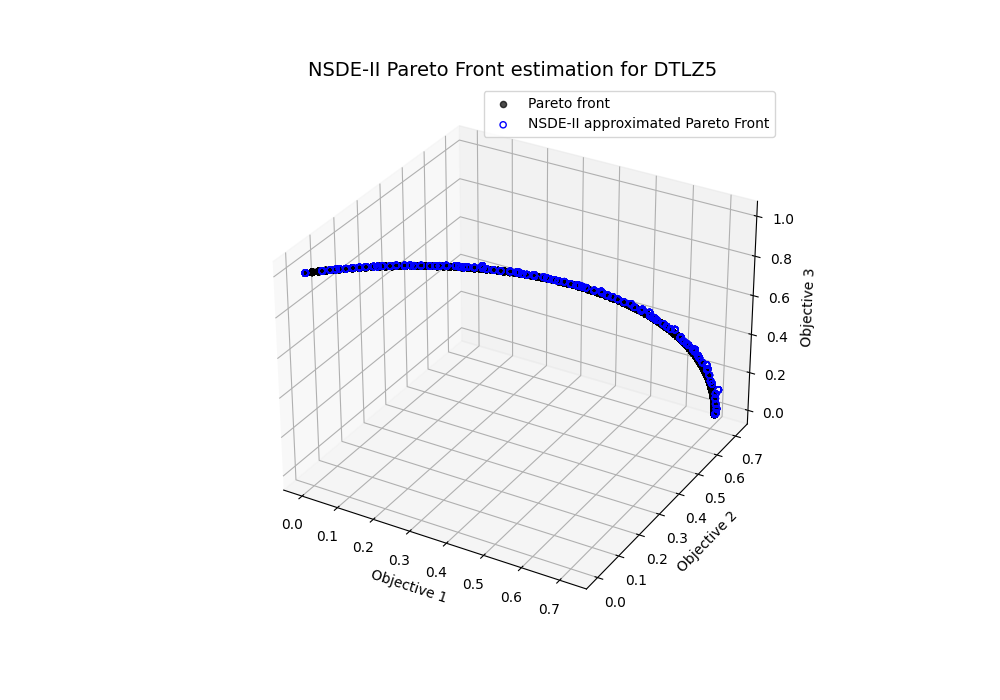

In [31]:
plot_results("results/DTLZ5.txt", "DTLZ5", dtlz5)

In the Pareto front estimations for DTLZ5, both NSGA-II and NSDE-II exhibit a strong alignment with the true Pareto front. The NSGA-II approximated front demonstrates a more consistent and dense distribution across the curved front, suggesting better convergence and diversity in some regions. On the other hand, NSDE-II also approximates the Pareto front well but shows slightly sparser coverage in specific areas, potentially reflecting less uniformity. The performance of both algorithms for this problem is commendable, with NSGA-II showing slight superiority in maintaining a well-spread distribution along the curve.

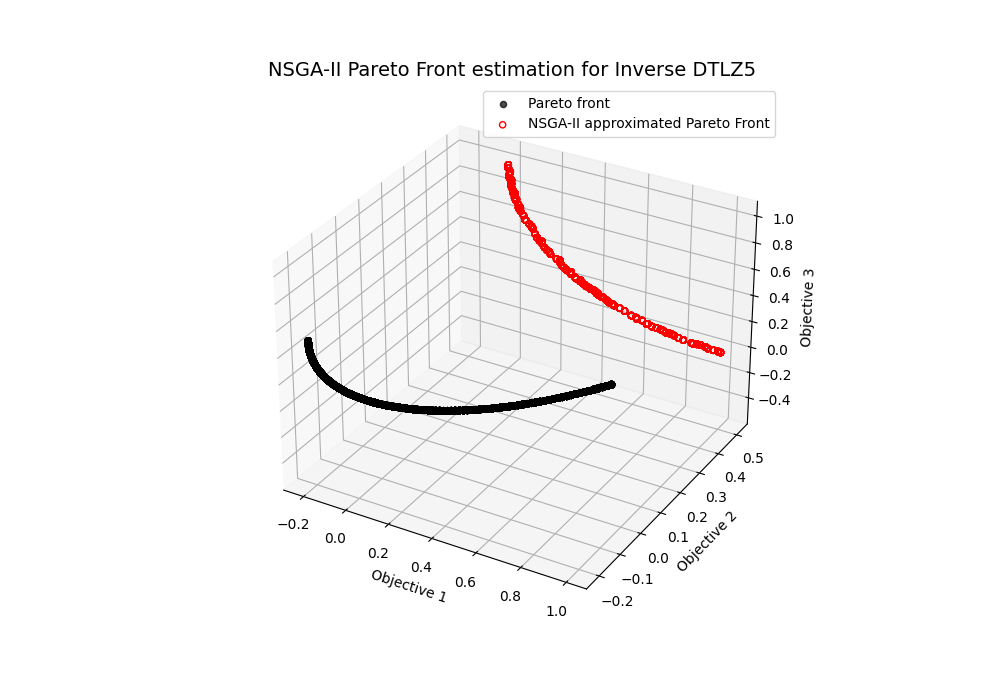

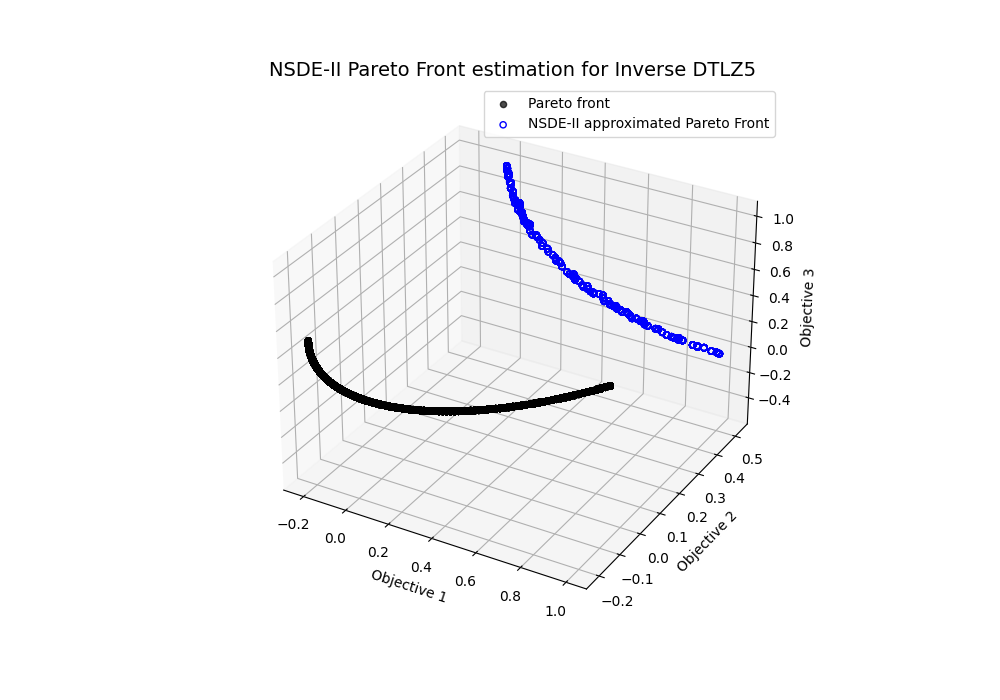

In [32]:
plot_results("results/Inverse_DTLZ5.txt", "Inverse DTLZ5", dtlz5, i_problem=True)

The Pareto front estimations for Inverse DTLZ5 show similar performance differences between NSGA-II and NSDE-II. In both plots, the algorithms fail to approximate the complex curve of the inverted Pareto front. NSGA-II achieves a closer alignment with the true front along a broader section but underperforms overall, indicating challenges in maintaining diversity at the extremes. NSDE-II follows the general structure of the front but displays slightly more dispersion and, as NSGA-II, the solutions remain far-away from the Pareto front, suggesting a trade-off between convergence and spread. Both algorithms fail to capture the curvature of the inverted front, but NSGA-II demonstrates a marginally tighter fit, making it more competitive for this problem.

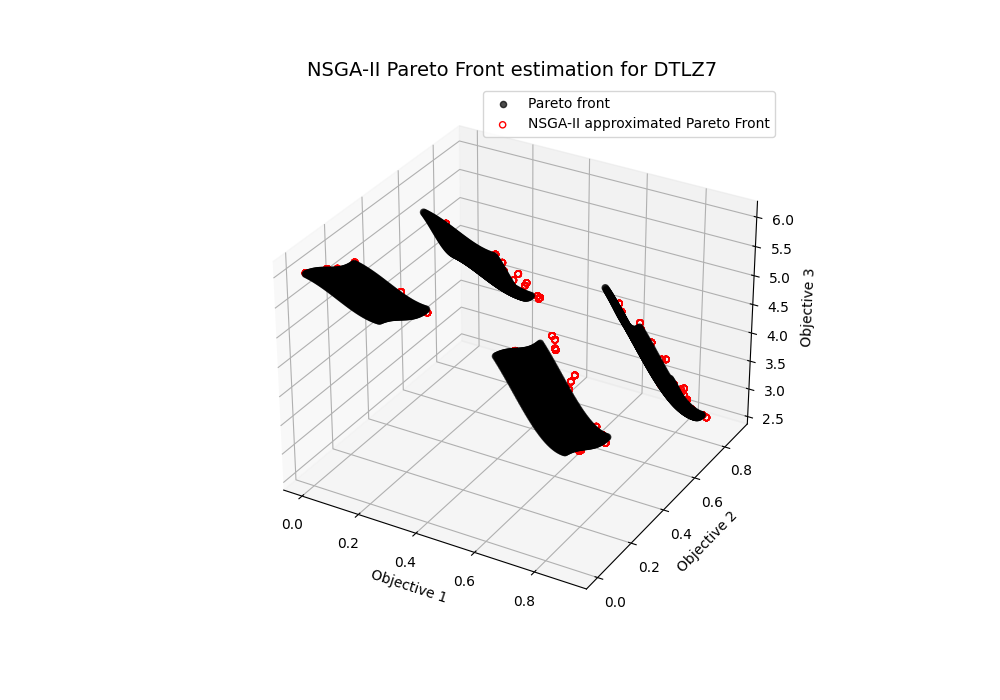

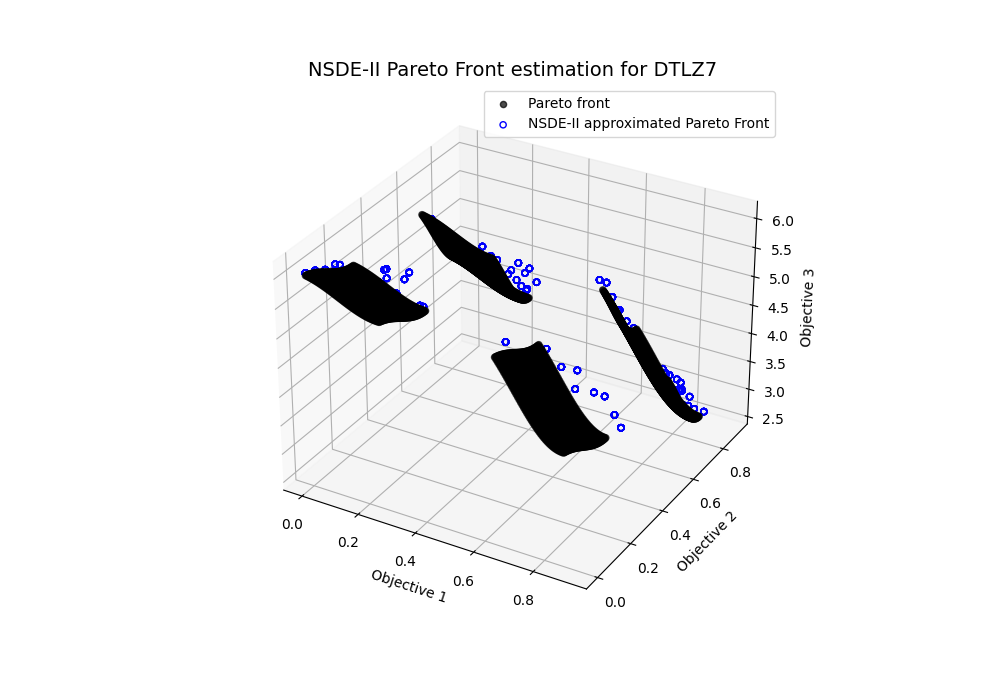

In [33]:
plot_results("results/DTLZ7.txt", "DTLZ7", dtlz7)

The Pareto front approximations for DTLZ7 by both NSGA-II and NSDE-II algorithms demonstrate similar clustering due to the nature of the objective functions. NSGA-II captures the discontinuous and spread-out regions of the Pareto front with reasonable accuracy but shows gaps and fewer points in certain clusters. On the other hand, NSDE-II appears more consistent in populating the clusters, although it occasionally spreads beyond the precise Pareto front boundaries.

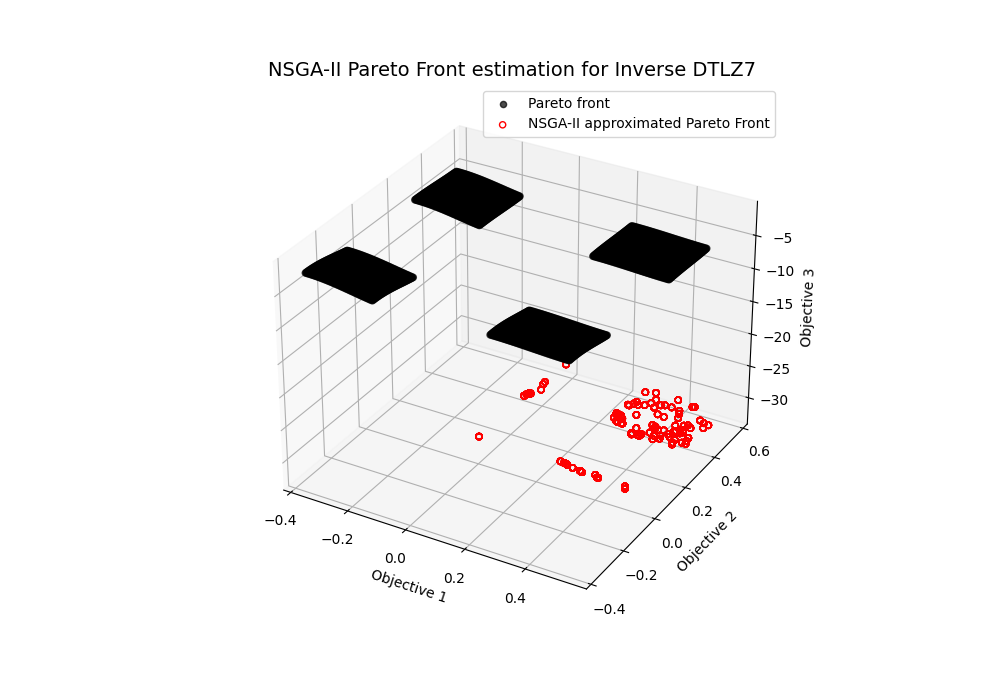

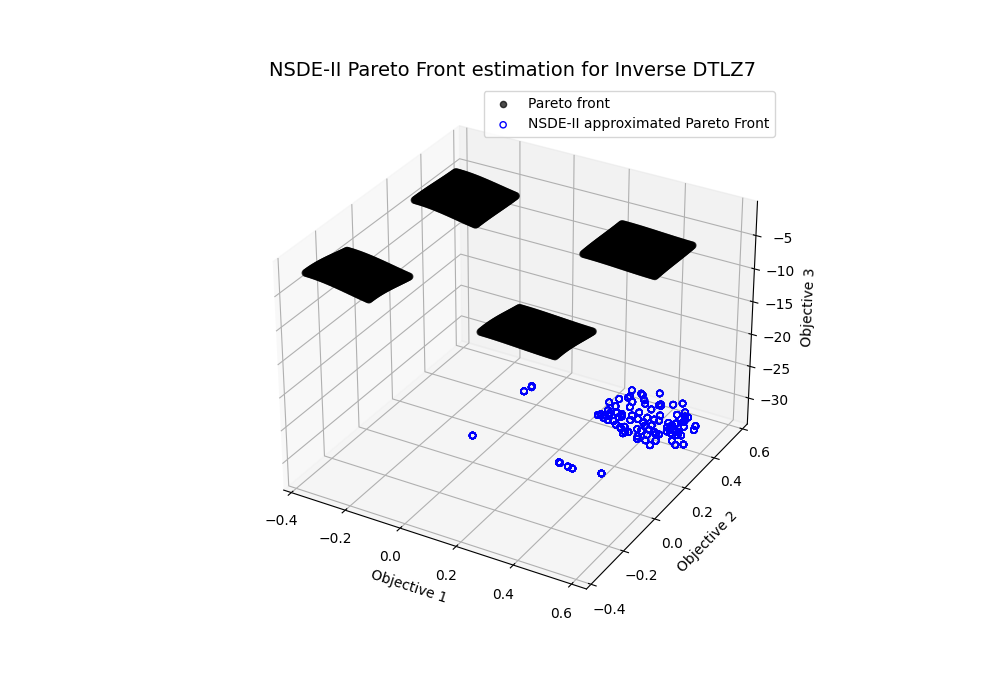

In [34]:
plot_results("results/Inverse_DTLZ7.txt", "Inverse DTLZ7", dtlz7, i_problem=True)

For the Inverse DTLZ7 plots, NSGA-II approximates the Pareto front segments with better spread and coverage, but the alignment appears slightly offset from the actual Pareto front in some regions. NSDE-II, however, produces solutions concentrated at the lower segments of the objective space, leaving larger gaps in the upper segments and missing some discontinuities entirely. Both algorithms struggle to fully capture the complexity of the inverse front but exhibit different tendencies in solution distribution.

## Conclusions.

In this study, we explored the performance of two multi-objective optimization algorithms, NSGA-II and NSDE-II, across a range of DTLZ and Inverse DTLZ problems. The experimentation provided valuable insights into the behavior and effectiveness of these algorithms in terms of convergence and diversity metrics, specifically the $R2$ indicator and the Riesz $s$-energy.

NSGA-II consistently demonstrated superior performance in terms of the $R2$ indicator, indicating better convergence towards the true Pareto front across most problem instances. This result reflects its effectiveness in minimizing the distance to the optimal front. Conversely, NSDE-II often excelled in Riesz $s$-energy, showcasing its strength in maintaining diversity across the Pareto front. This is particularly evident in problems requiring more evenly distributed solutions, where NSDE-II’s diversity-preserving approach proved beneficial.

For specific problem types, the algorithms showed distinct advantages. In problems such as DTLZ1 and its inverse counterparts, NSGA-II outperformed in convergence metrics, while NSDE-II’s ability to spread solutions more effectively was noticeable. In highly complex landscapes like DTLZ7, NSDE-II’s differential evolution operators contributed to greater solution diversity, though sometimes at the expense of slightly higher R2 values, reflecting a trade-off between convergence and diversity.

The study also highlighted the critical importance of balancing convergence and diversity in multi-objective optimization. While NSGA-II generally achieves stronger convergence, NSDE-II’s capacity to maintain a diverse spread of solutions suggests its advantages in applications that require broader exploration of the objective space. This diversity is particularly valuable in problems with highly non-linear or multi-modal Pareto fronts.

Finally, the statistical analysis, using Wilcoxon rank-sum tests, validated the observed performance differences between the two algorithms, confirming statistically significant variations in their performance metrics across all problem instances. In conclusion, the choice between NSGA-II and NSDE-II depends heavily on the specific requirements of the optimization task. NSGA-II is better suited for tasks where convergence to the Pareto front is paramount, while NSDE-II provides an advantage in maintaining diversity. Future research could explore hybrid approaches to integrate the strengths of both algorithms for improved performance across diverse optimization landscapes.